In [1]:
import sys
sys.path.append('../')
import numpy as np
import time
import tucker.tucker as tuck

from mesh.read_starcd import Mesh

import solver.solver_tucker as Boltzmann
import pickle

# compute parameters for flow around cylinder

# Parameters for argon (default)
gas_params = Boltzmann.GasParams()

Mach = 6.5
Kn = 0.564
delta = 8.0 / (5 * np.pi**0.5 * Kn)
n_l = 2e+23
T_l = 200.
u_l = Mach * ((gas_params.g * gas_params.Rg * T_l) ** 0.5)
T_w = 5.0 * T_l

n_s = n_l
T_s = T_l

p_s = gas_params.m * n_s * gas_params.Rg * T_s

v_s = np.sqrt(2. * gas_params.Rg * T_s)
mu_s = gas_params.mu(T_s)

l_s = delta * mu_s * v_s / p_s

n_r = (gas_params.g + 1.) * Mach * Mach / ((gas_params.g - 1.) * Mach * Mach + 2.) * n_l
u_r = ((gas_params.g - 1.) * Mach * Mach + 2.) / ((gas_params.g + 1.) * Mach * Mach) * u_l
T_r = (2. * gas_params.g * Mach * Mach - (gas_params.g - 1.)) * ((gas_params.g - 1.) * Mach * Mach + 2.) / ((gas_params.g + 1) ** 2 * Mach * Mach) * T_l

#print 'l_s = ', l_s

#print 'v_s = ', v_s

nv = 44
vmax = 22 * v_s

hv = 2. * vmax / nv
vx_ = np.linspace(-vmax+hv/2, vmax-hv/2, nv) # coordinates of velocity nodes

v = Boltzmann.VelocityGrid(vx_, vx_, vx_)

def f_init(x, y, z, v):
    if (x <= 0.):
        return Boltzmann.f_maxwell_tuck(v, n_l, u_l, 0., 0., T_l, gas_params.Rg)
    else:
        return Boltzmann.f_maxwell_tuck(v, n_r, u_r, 0., 0., T_r, gas_params.Rg)

f_in = Boltzmann.f_maxwell_tuck(v, n_l, u_l, 0., 0., T_l, gas_params.Rg)
f_out = Boltzmann.f_maxwell_tuck(v, n_r, u_r, 0., 0., T_r, gas_params.Rg)

#print(f_bound)
fmax = Boltzmann.f_maxwell_tuck(v, 1., 0., 0., 0., T_w, gas_params.Rg)
#print(fmax)
problem = Boltzmann.Problem(bc_type_list = ['sym-z', 'in', 'out', 'wall', 'sym-y'],
                                bc_data = [[],
                                           [f_in],
                                           [f_out], # TODO: substitute right values
                                           [fmax],
                                           []], f_init = f_init)


#print 'vmax =', vmax

config = Boltzmann.Config(solver = 'impl', CFL = 50., tol = 1e-3, tec_save_step = 10)

path = '../mesh/mesh-shock/'
mesh = Mesh()
mesh.read_starcd(path, l_s)

# =============================================================================
# f = open('../mesh/mesh-cyl/mesh-cyl.pickle', 'rb')
# mesh = pickle.load(file = f)
# f.close()
# =============================================================================

print('Initialization...')
t1 = time.clock()
S = Boltzmann.Solution(gas_params, problem, mesh, v, config)
t2 = time.clock()
print('Complete! Took', str(t2 - t1), 'seconds')

Number of boundary faces =  322
Number of boundary conditions =  4
Number of cells =  80
Number of vertices =  324
Number of faces =  401
sum of volumes: 4.910813089423168e-14
Initialization...
Complete! Took 38.765375999999996 seconds


In [2]:
# reconstruction for inner faces
# 1st order
for ic in range(S.mesh.nc):
    for j in range(6):
        jf = S.mesh.cell_face_list[ic, j]
        if (S.mesh.cell_face_normal_direction[ic, j] == 1):
            S.f_minus[jf] = S.f[ic].copy()
        else:
            S.f_plus[jf] = S.f[ic].copy()

# boundary condition
# loop over all boundary faces
for j in range(S.mesh.nbf):
    jf = S.mesh.bound_face_info[j, 0] # global face index
    bc_num = S.mesh.bound_face_info[j, 1]
    bc_type = S.problem.bc_type_list[bc_num]
    bc_data = S.problem.bc_data[bc_num]
    if (S.mesh.bound_face_info[j, 2] == 1):
        S.f_plus[jf] = Boltzmann.set_bc(S.gas_params, bc_type, bc_data, S.f_minus[jf], S.v, S.vn[jf], S.vnp[jf], S.vnm[jf], config.tol)
    else:
        S.f_minus[jf] = Boltzmann.set_bc(S.gas_params, bc_type, bc_data, S.f_plus[jf], S.v, -S.vn[jf], -S.vnm[jf], -S.vnp[jf], config.tol)

# riemann solver - compute fluxes
for jf in range(S.mesh.nf):
    S.flux[jf] = 0.5 * S.mesh.face_areas[jf] * \
    ((S.f_plus[jf] + S.f_minus[jf]) * S.vn[jf]  - (S.f_plus[jf] - S.f_minus[jf]) * S.vn_abs[jf])
    S.flux[jf] = S.flux[jf].round(config.tol)

# computation of the right-hand side
for ic in range(S.mesh.nc):
    S.rhs[ic] = S.v.zero.copy()
    # sum up fluxes from all faces of this cell
    for j in range(6):
        jf = S.mesh.cell_face_list[ic, j]
        S.rhs[ic] += -(S.mesh.cell_face_normal_direction[ic, j]) * (1. / S.mesh.cell_volumes[ic]) * S.flux[jf]
        S.rhs[ic] = S.rhs[ic].round(config.tol)
    # Compute macroparameters and collision integral
    J, S.n[ic], S.ux[ic], S.uy[ic], S.uz[ic], S.T[ic], S.rho[ic], S.p[ic], S.nu[ic] = \
    Boltzmann.comp_j(S.f[ic], S.v, S.gas_params)
    S.rhs[ic] += J # ? Is it correct?
    S.rhs[ic] = S.rhs[ic].round(config.tol)

In [3]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import numpy as np
from matplotlib import rcParams
import pickle

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

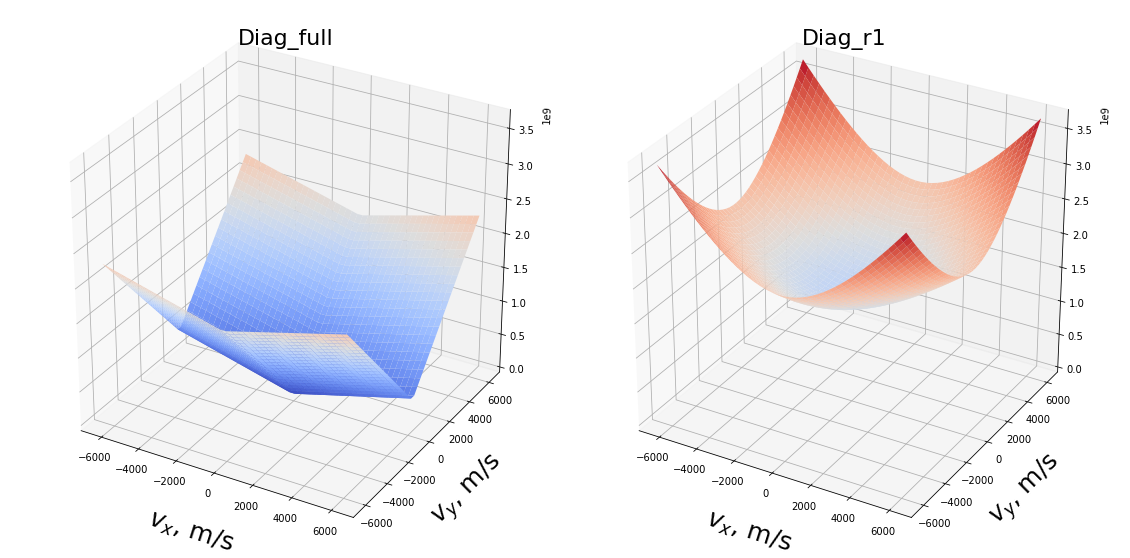

In [4]:
ic = mesh.nc//2
nv = v.nvz

X = v.vx[:, 0, 0]
Y = v.vy[0, :, 0]

X, Y = np.meshgrid(X, Y)

diag_temp = np.zeros((v.nvx, v.nvy, v.nvz))
diag_sc = 0.
for j in range(6):
    jf = mesh.cell_face_list[ic, j]
    vn_full = (mesh.face_normals[jf, 0] * v.vx + mesh.face_normals[jf, 1] * v.vy \
               + mesh.face_normals[jf, 2] * v.vz) * mesh.cell_face_normal_direction[ic, j]
    vnp_full = np.where(vn_full > 0, vn_full, 0.)
    vn_abs_full = np.abs(vn_full)
    diag_temp += (mesh.face_areas[jf] / mesh.cell_volumes[ic]) * vnp_full
    diag_sc += 0.5 * (mesh.face_areas[jf] / mesh.cell_volumes[ic])
diag_r1 = diag_sc * S.vn_abs_r1

fig = plt.figure(figsize = (20, 10))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X, Y, diag_temp[:, :, nv//2], vmin = np.min(diag_temp[:, :, nv//2]), vmax = np.max(diag_r1.full()[:, :, nv//2]), cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
ax1.set_zlim(0., np.max(diag_r1.full()[:, :, nv//2]))

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X, Y, diag_r1.full()[:, :, nv//2], vmin = np.min(diag_temp[:, :, nv//2]), vmax = np.max(diag_r1.full()[:, :, nv//2]), cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
ax2.set_zlim(0., np.max(diag_r1.full()[:, :, nv//2]))

#ax1.set_title('$\hat{D}_i$', fontsize = 22)
#ax2.set_title('$\hat{D}_i^{est}$', fontsize = 22)
ax1.set_title('Diag_full', fontsize = 22)
ax2.set_title('Diag_r1', fontsize = 22)

for ax in (ax1, ax2):
    ax.set_xlabel('$v_x$, m/s', fontsize = 25, labelpad = 20)
    ax.set_ylabel('$v_y$, m/s', fontsize = 25, labelpad = 20)

fig.subplots_adjust(wspace = 0.)

#plt.show()
#plt.savefig('diag.eps', dpi = 600, bbox_inches='tight')
plt.savefig('diag.png', dpi = 100, bbox_inches='tight')

In [26]:
for ic in range(S.mesh.nc - 1, -1, -1):
    S.df[ic] = S.rhs[ic].copy()
    print(ic, (S.f[ic]).norm())

79 1080453895427943.8
78 1080453895427943.8
77 1080453895427943.8
76 1080453895427943.8
75 1080453895427943.8
74 1080453895427943.8
73 1080453895427943.8
72 1080453895427943.8
71 1080453895427943.8
70 1080453895427943.8
69 1080453895427943.8
68 1080453895427943.8
67 1080453895427943.8
66 1080453895427943.8
65 1080453895427943.8
64 1080453895427943.8
63 1080453895427943.8
62 1080453895427943.8
61 1080453895427943.8
60 1080453895427943.8
59 1080453895427943.8
58 1080453895427943.8
57 1080453895427943.8
56 1080453895427943.8
55 1080453895427943.8
54 1080453895427943.8
53 1080453895427943.8
52 1080453895427943.8
51 1080453895427943.8
50 1080453895427943.8
49 1080453895427943.8
48 1080453895427943.8
47 1080453895427943.8
46 1080453895427943.8
45 1080453895427943.8
44 1080453895427943.8
43 1080453895427943.8
42 1080453895427943.8
41 1080453895427943.8
40 1080453895427943.8
39 2058149736079496.8
38 2058149736079496.8
37 2058149736079496.8
36 2058149736079496.8
35 2058149736079496.8
34 2058149

In [27]:
for ic in range(S.mesh.nc - 1, -1, -1):
    # loop over neighbors of cell ic
    for j in range(6):
        jf = S.mesh.cell_face_list[ic, j]
        icn = S.mesh.cell_neighbors_list[ic, j] # index of neighbor
        if S.mesh.cell_face_normal_direction[ic, j] == 1:
            vnm_loc = 0.5 * (S.vn[jf] - S.vn_abs_r1) # vnm[jf]
        else:
            vnm_loc = - 0.5 * (S.vn[jf] + S.vn_abs_r1) # -vnp[jf]
        if ((icn >= 0 ) and (icn > ic)):
            print(ic, (S.df[ic]).norm())
            S.df[ic] += -(S.mesh.face_areas[jf] / S.mesh.cell_volumes[ic]) \
            * vnm_loc * S.df[icn]
            print(ic, (S.df[ic]).norm())
            S.df[ic] = S.df[ic].round(config.tol)
            print(ic, (S.df[ic]).norm())
    # divide by diagonal coefficient
    diag_temp = ((1./S.tau + S.nu[ic]) * S.v.ones + S.diag_r1[ic]).round(1e-3, rmax = 1)
    S.df[ic] = tuck.div_1r(S.df[ic], diag_temp)

78 47561890478.61917
78 9.541096987568833e+21
78 9.54109697835198e+21
77 47494829031.93829
77 2.1172287195163166e+33
77 2.1172287174062952e+33
76 47481606082.924164
76 5.225183117705109e+44
76 5.2251831092943855e+44
75 47460580791.38971
75 1.4211617145156944e+56
75 1.421161710167732e+56
74 47481606082.924164
74 4.180557702073348e+67
74 4.18055768206838e+67
73 47481606082.924164
73 1.3097881197022447e+79
73 1.3097881125226582e+79
72 47460580791.38971
72 4.340117431479859e+90
72 4.340117409144466e+90
71 47460580791.38971
71 1.522862646549912e+102
71 1.522862640232807e+102
70 47481606082.924164
70 5.7147425832624074e+113
70 5.714742567817653e+113
69 47481606082.924164
69 2.3344635313721008e+125
69 2.334463528338591e+125
68 47481606082.924164
68 1.0532659130261266e+137
68 1.0532659125449946e+137
67 47460580791.38971
67 5.219595387133722e+148
67 5.219595386434378e+148
66 47415090434.92639
66 inf
66 inf
65 47481606082.924164
65 inf
65 inf
64 47460580791.38971
64 inf
64 inf
63 47481606082.924

LinAlgError: SVD did not converge

In [7]:
G = (vnm_loc * S.df[icn])
print(vnm_loc)
print(S.rhs[icn])
print(G)

This is a 3D tensor in the Tucker format with 
r(0)=4, n(0)=44 
r(1)=4, n(1)=44 
r(2)=4, n(2)=44 

This is a 3D tensor in the Tucker format with 
r(0)=3, n(0)=44 
r(1)=3, n(1)=44 
r(2)=3, n(2)=44 

This is a 3D tensor in the Tucker format with 
r(0)=12, n(0)=44 
r(1)=12, n(1)=44 
r(2)=12, n(2)=44 



In [ ]:
#S.f[ic] = (S.f[ic] + S.tau * S.rhs[ic]).round(config.tol)

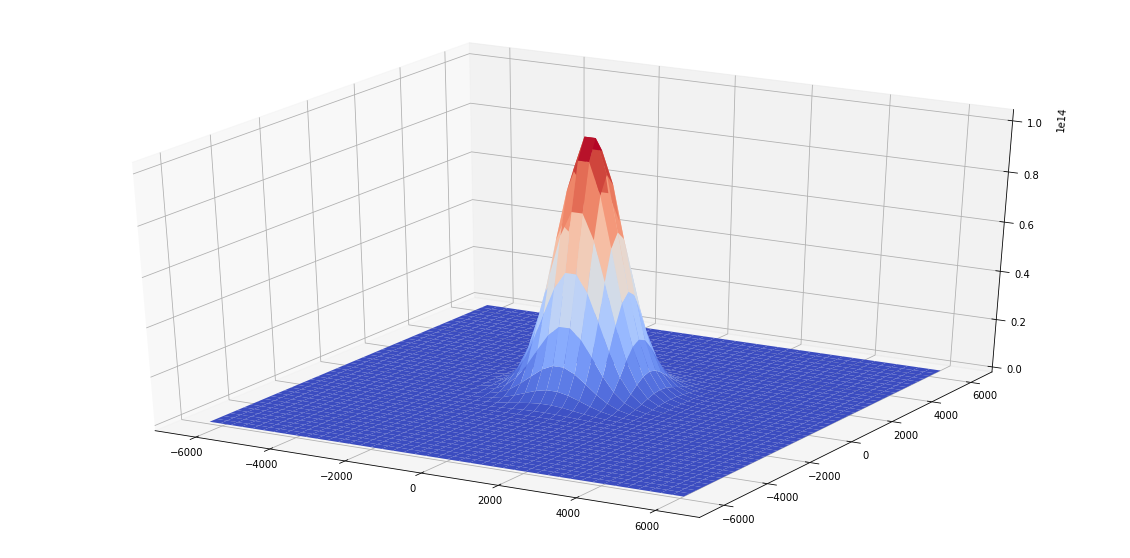

In [15]:
fig = plt.figure(figsize = (20, 10))

ax1 = fig.add_subplot(1, 1, 1, projection='3d')
surf1 = ax1.plot_surface(X, Y, S.df[40].full()[:, :, nv//2], cmap=cm.coolwarm, linewidth=0, antialiased=True)
#ax1.zaxis.set_scale('log')
plt.show()

In [ ]:
5. * 

In [ ]:
np.min(G.full())

In [ ]:
AAA = np.ones((12, 12))
t1 = time.time()
100. * AAA
t2 = time.time()
print(t2 - t1)